In [1]:
%load_ext autoreload
%autoreload 1
%aimport ECGDataset
%aimport Models
%aimport train_test_validat
%aimport self_attention
%aimport ECGplot
%aimport Net
import ECGDataset 
import Models 
import Net
from train_test_validat import *
from self_attention import *
import matplotlib.pyplot as plt
import ecg_plot

import torch
import torch.utils.data as Data
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
import random
import pandas as pd

import time
import math
import os
import gc

# random_seed = 2
# torch.manual_seed(random_seed)    # reproducible
# torch.cuda.manual_seed_all(random_seed)
# random.seed(random_seed)
# np.random.seed(random_seed)

time_str = time.strftime("%Y%m%d_%H%M%S", time.localtime()) 

In [2]:
model_path = './model/'+time_str
log_path = './logs/'+  time_str

EcgChannles_num = 12
EcgLength_num = 5000
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda:0


In [3]:
ALLDataset = ECGDataset.ECG_Dataset_Init('/workspace/data/Preprocess_HTN/data_like_pxl/')

              HTN        NHTN   
   nums       1871      103183  


            orginal            QC         
   nums      105054          65944        
              HTN        NHTN   
   nums       1344      64600   


            orginal   filtered department 
   nums      65944           13953        
              HTN        NHTN   
   nums       1344      12609   


            orginal     removed ages NaN  
   nums      13953           13953        
              HTN        NHTN   
   nums       1344      12609   
              HTN        NHTN   
   nums       1344      12609   


            orginal   removed diagnose NaN
   nums      13953           13949        
              HTN        NHTN   
   nums       1344      12605   


              HTN        NHTN   
   ALL        1344      12605   
 testset      346        5245   
 T&V set      998        7360   


In [4]:
ALLDataset.report()  # type: ignore

              HTN        NHTN   
 TestSet      346        5245   
  TVSet       998        7360   
   ALL        1344      12605   
              ECGs      Labels  
TestShape  (5591, 12, 5000)  (5591,)  
 TVShape   (8358, 12, 5000)  (8358,)  
              HTN        NHTN   
 TestSet      346        5245   
  TVSet       998        7360   


In [5]:
BATCH_SIZE = 128

FOLDS = 2
EPOCHS = 100  
PATIENCE = 10
LR = 0.01


tensor([1., 0.])


False

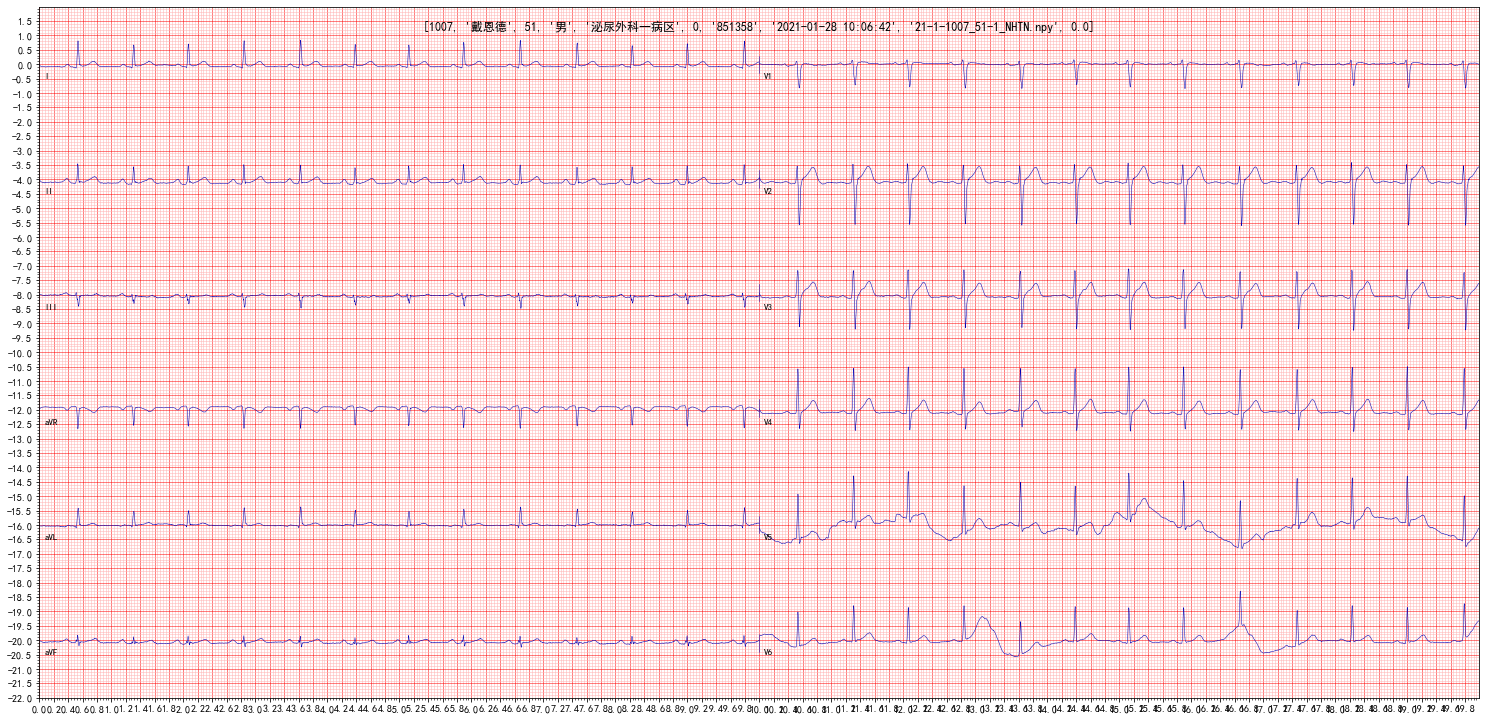

In [12]:
test_dataset = ECGDataset.ECG_Dataset(ALLDataset.testECGs,ALLDataset.testLabels,ALLDataset.testDf,preprocess= True,num_classes = 2)  # type: ignore
x,y = test_dataset.__getitem__(0)
print(y)
ecg_plot.plot(x*3.5,500,(test_dataset.info(0)).tolist(),columns=2,row_height= 8,show_grid=True,show_separate_line=True)  # type: ignore
test_dataset.infos['diagnose'].tolist() == test_dataset.labels.tolist() # type: ignore)

In [7]:
torch.cuda.empty_cache()# 清空显卡cuda
NET = [Net.MLBFNet(True,res = True,se = True,Dropout_rate = 0.25) ]*FOLDS # type: ignore

In [8]:
from torch.utils.tensorboard import SummaryWriter
os.makedirs(model_path, exist_ok=True)
writer = SummaryWriter(log_path)
# writer.add_graph(NET[0], torch.zeros((1,12,5000)))  #模型及模型输入数据
torch.cuda.empty_cache()# 清空显卡cuda

In [9]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, weight=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.weight = weight
        self.reduction = reduction

    def forward(self, output, target):
        # convert output to pseudo probability
        out_target = torch.stack([output[i, t] for i, t in enumerate(target)])
        probs = torch.sigmoid(out_target)
        focal_weight = torch.pow(1-probs, self.gamma)

        # add focal weight to cross entropy
        ce_loss = torch.nn.functional.cross_entropy(output, target, weight=self.weight, reduction='none')
        focal_loss = focal_weight * ce_loss

        if self.reduction == 'mean':
            focal_loss = (focal_loss/focal_weight.sum()).sum()
        elif self.reduction == 'sum':
            focal_loss = focal_loss.sum()

        return focal_loss

In [13]:
skf = StratifiedKFold(n_splits=FOLDS, random_state=None, shuffle=False)
fold = 0

train_loss_sum =[0]*FOLDS
train_acc_sum = [0]*FOLDS
validate_loss_sum = [0]*FOLDS
validate_acc_sum = [0]*FOLDS
test_loss_sum = [0]*FOLDS
test_acc_sum = [0]*FOLDS



for train_index, val_index in skf.split(ALLDataset.TVECGs, ALLDataset.TVLabels):
    # print("TRAIN:", train_index, "TEST:", val_index)
    train_datas = ALLDataset.TVECGs[train_index]
    train_labels = ALLDataset.TVLabels[train_index]
    train_infos = ALLDataset.TVDf.iloc[train_index]
    criterion = torch.nn.CrossEntropyLoss()
    criterion = FocalLoss()
    # train_dataset =  ECGDataset.ECG_Dataset(train_datas,train_labels,train_infos,preprocess = True,num_classes = 2)  # type: ignore

    val_datas = ALLDataset.TVECGs[val_index]
    val_labels = ALLDataset.TVLabels[val_index]
    val_infos = ALLDataset.TVDf.iloc[val_index]
    val_dataset =  ECGDataset.ECG_Dataset(val_datas,val_labels,val_infos,preprocess = True,num_classes = 2)  # type: ignore

    train_loss,train_acc,validate_loss,validate_acc,test_loss,test_acc = tarinning_one_flod(fold,NET[fold],train_dataset,val_dataset,test_dataset,writer,model_path
                                                                                            ,BATCH_SIZE = BATCH_SIZE,
                                                                                            DEVICE=DEVICE,
                                                                                            criterion = criterion)
    train_loss_sum[fold] = train_loss
    train_acc_sum[fold] = train_acc
    validate_loss_sum[fold] = validate_loss
    validate_acc_sum[fold] = validate_acc
    test_loss_sum[fold] = test_loss
    test_acc_sum[fold] = test_acc
    torch.cuda.empty_cache()# 清空显卡cuda
    fold = fold + 1
print("\n train_loss",train_loss_sum,
      "\n train_acc",train_acc_sum,
      "\n validate_loss",validate_loss_sum,
      "\n validate_acc",validate_acc_sum,
      "\n test_loss",test_loss_sum,
      "\n test_acc",test_acc_sum)
print('Training Finished')

RuntimeError: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.